In [1]:
import pandas as pd
from IPython.display import Image
from kid_readout.analysis import resonator, plot_resonator

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


The active volume (green) is 20 nm aluminum. The complex conductivity is what we expect at 200 mK if only thermal quasiparticles are present.
This gives surface resistance $R_s = 0.44 \, \mu \Omega / \square$ and surface reactance $X_s = 0.030 \, \Omega / \square$.
The inactive volume (pink) is lossless metal.

The substrate is silicon with zero conductivity and zero loss tangent.

The simulated resonator is pictured below.
The aluminum has a minimum subsection size in cells of $(n_x, n_y) = (1, 20)$, or $(2 \, \mu \mathrm{m}, 40 \, \mu \mathrm{m})$, with no edge meshing.
The niobium has a minimum subsection size in cells of $(n_x, n_y) = (5, 5)$, or $(10 \, \mu \mathrm{m}, 10 \, \mu \mathrm{m})$, with no edge meshing.

Port 3 is shorted: its internal resistance is $0 \, \Omega$.

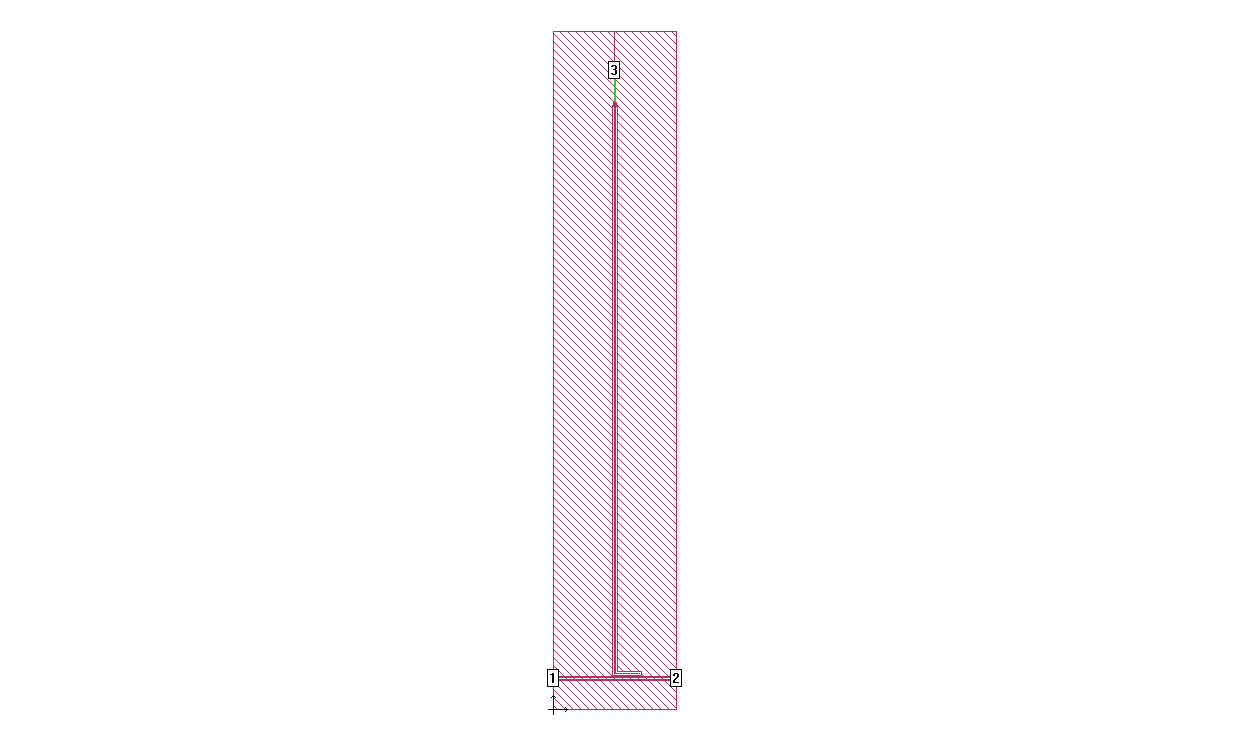

In [2]:
Image(filename='/Users/daniel/Dropbox/multichroic/Sonnet/one_hybrid_unwrapped/sonnet_full.png')

In [3]:
def rename(df):
    df = df.rename(columns={'Frequency (GHz)': 'Frequency_GHz'})
    df = df.rename(columns=lambda column: column.translate(None, '[]'))
    return df

In [4]:
z = rename(pd.read_csv('/Users/daniel/Dropbox/multichroic/Sonnet/one_hybrid_unwrapped/one_hybrid_unwrapped_Z.csv', header=7, delimiter=','))
z['f'] = 1e9 * z.Frequency_GHz

In [5]:
s = rename(pd.read_csv('/Users/daniel/Dropbox/multichroic/Sonnet/one_hybrid_unwrapped/one_hybrid_unwrapped_S.csv', header=7, delimiter=','))
s['f'] = 1e9 * s.Frequency_GHz

In [6]:
re_poly = np.polyfit(z.f, z.REZ33, 2)
im_poly = np.polyfit(z.f, z.IMZ33, 1)

f_r = -im_poly[1] / im_poly[0]
R = np.polyval(re_poly, f_r)
Q = im_poly[0] * f_r / (2 * R)

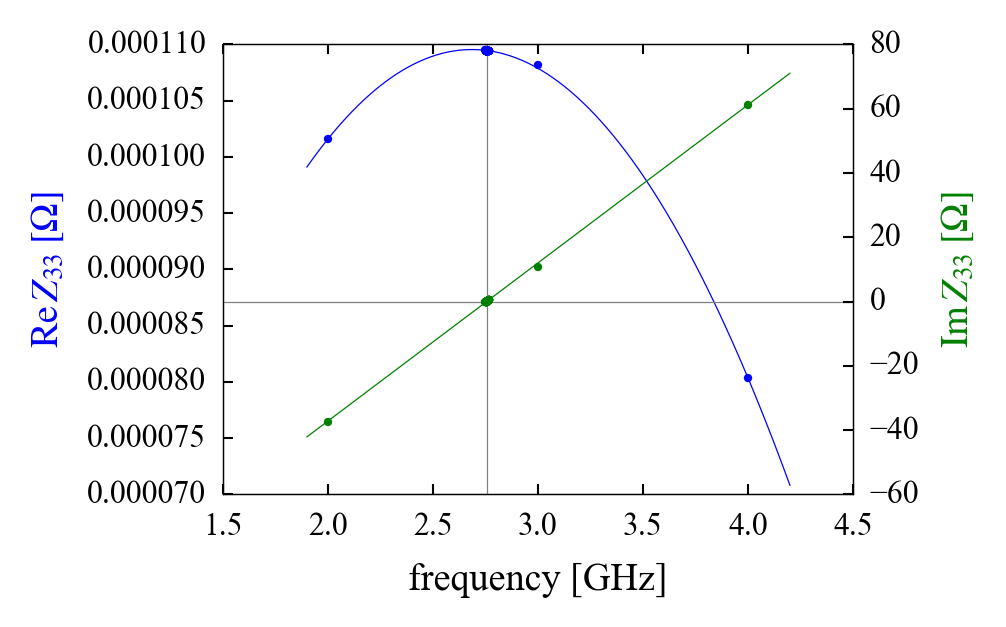

In [7]:
re_color = 'blue'
im_color = 'green'
scale = 1e-9
f_fit = np.linspace(0.95 * z.f.min(), 1.05 * z.f.max(), 1e3)
fig, re_ax = plt.subplots()
im_ax = re_ax.twinx()
im_ax.axhline(0, color='gray')
re_ax.axvline(scale * f_r, color='gray')
re_ax.plot(scale * z.f, z.REZ33, '.', color=re_color, label='re Z33')
re_ax.plot(scale * f_fit, np.polyval(re_poly, f_fit), color=re_color)
im_ax.plot(scale * z.f, z.IMZ33, '.', color=im_color, label='im Z33')
im_ax.plot(scale * f_fit, np.polyval(im_poly, f_fit), color=im_color)
re_ax.set_xlabel('frequency [GHz]')
re_ax.set_ylabel(r'$\mathrm{Re} \, Z_{33} \; [\Omega]$', color=re_color)
im_ax.set_ylabel(r'$\mathrm{Im} \, Z_{33} \; [\Omega]$', color=im_color);

As shown in the plot above, we fit a line to $\mathrm{Im} \, Z_{33}$ and a quadratic to $\mathrm{Re} \, Z_{33}$ to determine the parameters. The results are

In [8]:
print("Measured resonance f_r = {:.6f} [GHz]".format(1e-9 * f_r))
print("Quality factor Q = {:.2g}".format(Q))

Measured resonance f_r = 2.755673 [GHz]
Quality factor Q = 6.2e+05


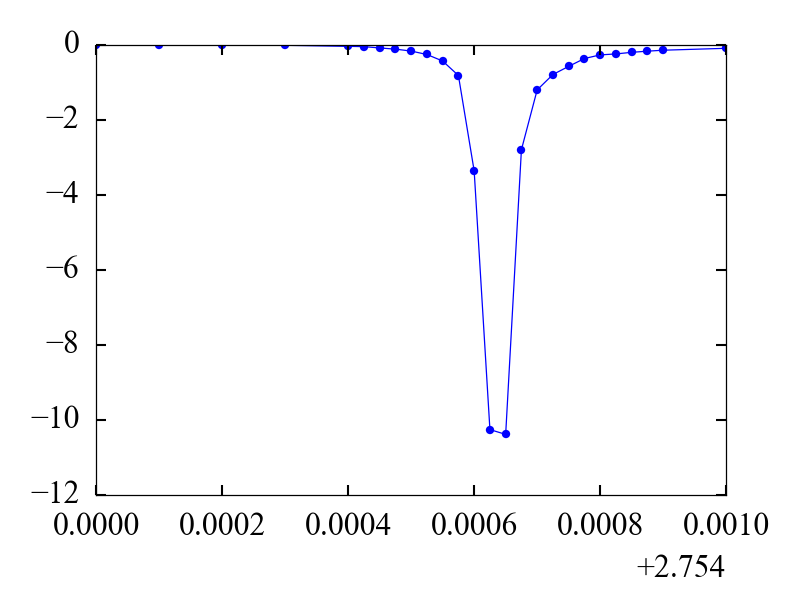

In [9]:
scale = 1e-9
fig, ax = plt.subplots()
ax.plot(scale * s.f, 20 * np.log10(np.abs(s.RES21 + 1j * s.IMS21)), '.-')
#ax.set_xlim(scale * 0.999 * f_r, scale * 1.001 * f_r)
ax.set_xlim(2.754, 2.755)
ax.axvline(scale * f_r, color='gray')

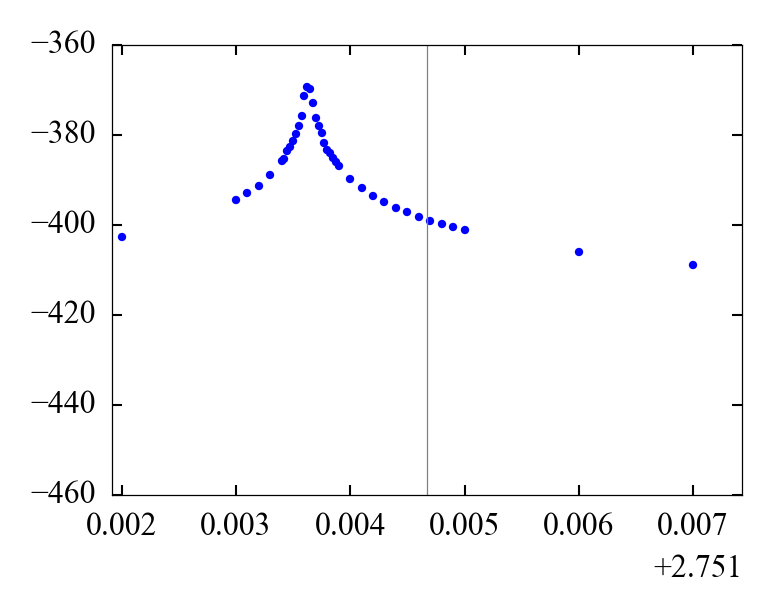

In [10]:
scale = 1e-9
fig, ax = plt.subplots()
ax.plot(scale * s.f, 20 * np.log10(np.abs(s.RES31 + 1j * s.IMS31)), '.')
ax.set_xlim(scale * 0.999 * f_r, scale * 1.001 * f_r)
ax.axvline(scale * f_r, color='gray')

In [11]:
from scipy.constants import c
a = 10.3e-3
epsilon_r = 11.9
epsilon_eff = (1 + epsilon_r) / 2
v = c / epsilon_eff**(1/2)
f_0 = v / (4 * a)
print("Expected resonance f_0 = {:.3f} [GHz]".format(1e-9 * f_0))

Expected resonance f_0 = 2.865 [GHz]


In [12]:
alpha = 1 - (f_r / f_0)**2
print("kinetic inductance fraction: {:.2f}".format(alpha))

kinetic inductance fraction: 0.07


In [13]:
linewidth = f_r / Q
linewidth

4451.2095243745171

In [14]:
def mask_s21(f, s21, linewidth, n):
    return np.abs(f - f[np.argmin(np.abs(s21))]) < n * linewidth

def fit_resonator(df, linewidth, n=20):
    f = np.array(df.f)
    s21 = np.array(df.RES21 + 1j * df.IMS21)
    mask = mask_s21(f, s21, linewidth, n)
    r = resonator.Resonator(f[mask], s21[mask])
    return r, mask

In [32]:
r, mask = fit_resonator(s, linewidth, n=100)

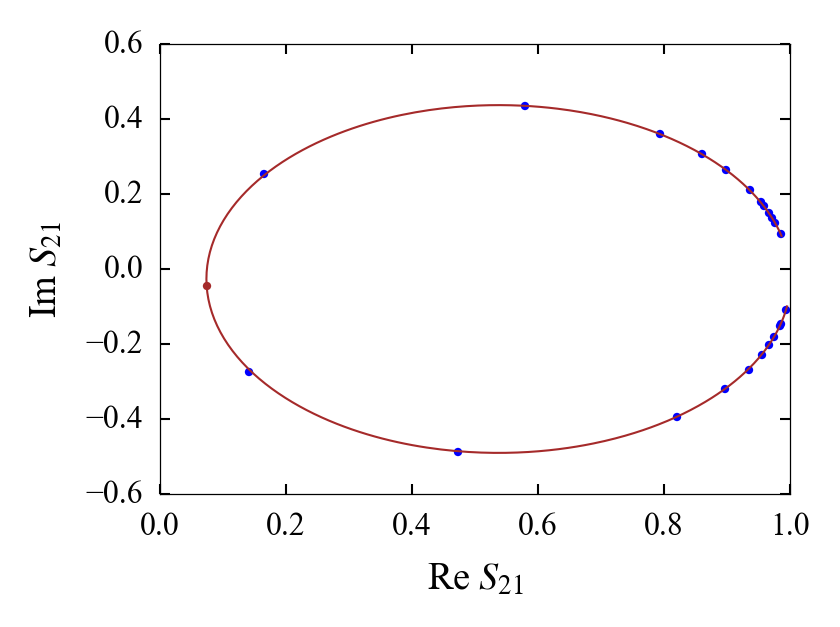

In [33]:
fig = plot_resonator.IQ_circle(r, normalize_s21=True)

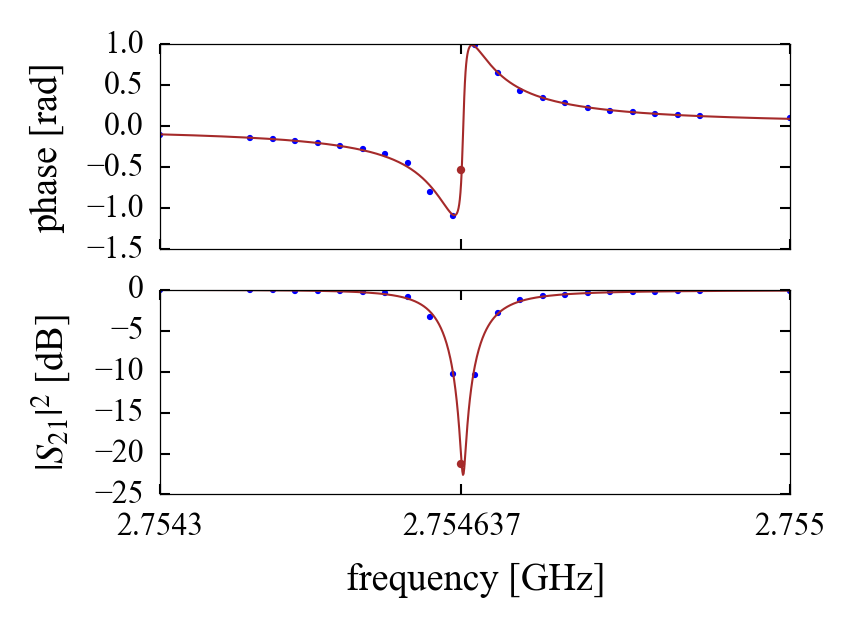

In [44]:
fig = plot_resonator.amplitude_and_phase(r, normalize_s21=True)
ax = fig.gca()
ax.xaxis.set_ticklabels(['2.7543', '2.754637', '2.755'])
ax.set_xlabel('frequency [GHz]');
fig.savefig('one_hybrid_unwrapped_resonator_fit.pdf', bbox_inches='tight')

In [19]:
r.Q_i

519080.79744314129

In [20]:
r.Q_e_real

41369.145655180459

In [21]:
r.Q

38424.12482704172

In [22]:
r.f_0 / r.Q

71690.23790425343